In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [ ]:
df = pd.read_csv("df-final(in).csv")

Converting/Verification

In [ ]:
df['merchant_state'] = df['merchant_state'].fillna('online')
df['zip'] = df['zip'].fillna('99999')
df['errors'] = df['errors'].fillna('no')

# --- Conversion en datetime ---
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['expires'] = pd.to_datetime(df['expires'], errors='coerce')
df['date_only'] = pd.to_datetime(df['date_only'], errors='coerce')
df['acct_open_date'] = pd.to_datetime(df['acct_open_date'], errors='coerce')

# --- Colonnes catégorielles ---
categorical_cols = ['card_type', 'card_brand', 'errors']

# Mapping automatique vers des nombres
for col in categorical_cols:
    df[col] = df[col].astype('category')
    df[col + '_num'] = df[col].cat.codes  # je crée une colonne numérique pour cette variable

# --- Colonnes restantes en string (non utilisées pour corrélation) ---
cols_string = ['use_chip', 'merchant_city', 'merchant_state', 'address', 'mcc_description']
df[cols_string] = df[cols_string].astype('string')

# --- Vérification ---
print(df.head())
print(df.dtypes)

#%%
# je convertis les dates en entiers (nanosecondes depuis 1970) pour pouvoir les utiliser comme variables numériques
df['date_num'] = df['date'].view('int64')
df['expires_num'] = df['expires'].view('int64')
df['date_only_num'] = df['date_only'].view('int64')
df['acct_open_date_num'] = df['acct_open_date'].view('int64')


                                          Unnamed: 0  transaction_id  \
0                                                  0      19765990.0   
1                                                  1      22160255.0   
2  2,17566794,2016-03-26 12:42:00,1967,3367,11.03...             NaN   
3  3,17318690,2016-02-01 08:30:00,921,3457,85.74,...             NaN   
4                                                  4      20994060.0   

                 date  client_id_x  card_id  amount          use_chip  \
0 2017-07-07 09:53:00       1581.0   2519.0   12.35  Chip Transaction   
1 2018-11-26 17:44:00       1862.0   4049.0   58.29  Chip Transaction   
2                 NaT          NaN      NaN     NaN              <NA>   
3                 NaT          NaN      NaN     NaN              <NA>   
4 2018-03-24 14:42:00        456.0   2800.0   13.43  Chip Transaction   

   merchant_id merchant_city merchant_state  ...    cvv  has_chip  \
0      20519.0        Arnold             MO  ...  446.0    

/tmp/ipython-input-1421140930.py:29: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df['date_num'] = df['date'].view('int64')
/tmp/ipython-input-1421140930.py:30: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df['expires_num'] = df['expires'].view('int64')
/tmp/ipython-input-1421140930.py:31: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df['date_only_num'] = df['date_only'].view('int64')
/tmp/ipython-input-1421140930.py:32: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df['acct_open_date_num'] = df['acct_open_date'].view('int64')


PCA

Top colonnes avec des NaN dans X :
transaction_id    38758
client_id_x       38758
card_id           38758
amount            38758
merchant_id       38758
mcc               38758
current_age       38758
retirement_age    38758
birth_year        38758
birth_month       38758
dtype: int64


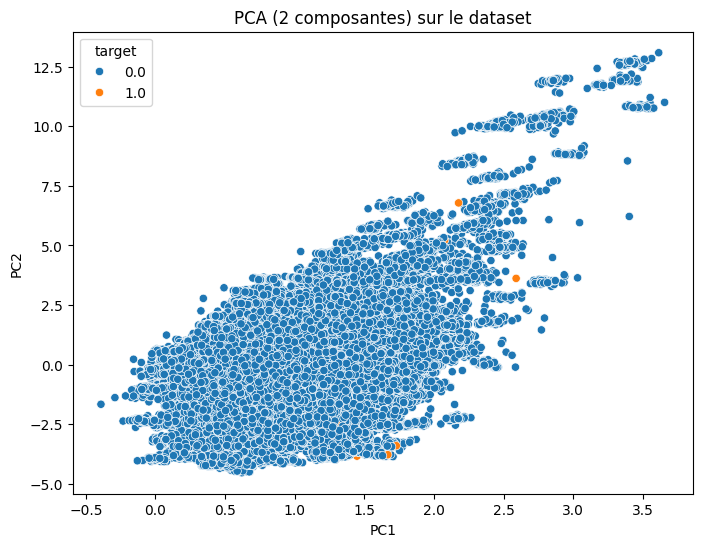

Composition des 5 composantes principales :
                            PC1       PC2       PC3       PC4       PC5
transaction_id         0.002447  0.000152 -0.002786  0.008703  0.024206
client_id_x           -0.019309  0.151065 -0.377984  0.566283  0.085946
card_id               -0.021124  0.020085 -0.011475 -0.005075 -0.004544
amount                 0.040042  0.060823 -0.029546 -0.064651 -0.064961
merchant_id            0.034009 -0.013943 -0.012607  0.026810  0.100362
mcc                    0.009874 -0.031944  0.002100 -0.037030  0.108297
current_age            0.020631 -0.303706 -0.482092 -0.205767 -0.201819
retirement_age         0.038258  0.019050 -0.043921 -0.097968  0.459900
birth_year            -0.018452  0.303079  0.482351  0.204971  0.205795
birth_month           -0.021684  0.013725  0.021875  0.089150 -0.210376
latitude              -0.045659  0.120381 -0.070536 -0.058992  0.101449
longitude             -0.073653  0.113894  0.004011 -0.070968  0.031985
per_capita_income   

In [ ]:
# --- Sélection des colonnes numériques ---
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'target' in numeric_cols:
    numeric_cols.remove('target')

X = df[numeric_cols]
y = df['target']

# je vérifie rapidement où il reste des NaN côté X
print("Top colonnes avec des NaN dans X :")
print(X.isna().sum().sort_values(ascending=False).head(10))

# --- Imputation des NaN dans X ---
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# --- Standardisation ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# =======================
# PCA à 2 composantes (visualisation)
# =======================
pca_2 = PCA(n_components=2)
principal_components_2 = pca_2.fit_transform(X_scaled)

pca_df_2 = pd.DataFrame(data=principal_components_2, columns=['PC1', 'PC2'])
pca_df_2['target'] = y.values

plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='target', data=pca_df_2)
plt.title('PCA (2 composantes) sur le dataset')
plt.show()

# =======================
# PCA à 5 composantes (analyse des loadings)
# =======================
n_components = 5
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=principal_components,
                      columns=[f'PC{i+1}' for i in range(n_components)])
pca_df['target'] = y.values

# --- Loadings des composantes principales ---
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(n_components)],
                        index=numeric_cols)
print("Composition des 5 composantes principales :")
print(loadings)

# --- Contribution de chaque composante par rapport à la target (R² simple) ---
# je filtre les lignes où target n'est pas NaN pour la régression
mask_target = y.notna()
y_valid = y[mask_target].values

contributions = {}
for i in range(n_components):
    model = LinearRegression()
    pc = principal_components[:, i].reshape(-1, 1)
    pc_valid = pc[mask_target]
    model.fit(pc_valid, y_valid)
    r2 = model.score(pc_valid, y_valid)
    contributions[f'PC{i+1}'] = r2

contrib_df = pd.DataFrame.from_dict(contributions, orient='index', columns=['R2_with_target'])
print("\nApport de chaque composante dans l'explication de la target :")
print(contrib_df)

Feature Engineering et Analyse par profil utilisateur

In [ ]:
# je crée une table agrégée par utilisateur
user_features = df.groupby('client_id_x').agg({
    'amount': ['mean', 'sum', 'std', 'count'],
    'date': 'max'
}).reset_index()

# je renomme les colonnes pour que ce soit propre
user_features.columns = ['client_id_x', 'mean_amount', 'sum_amount', 'std_amount', 'count_transactions', 'last_transaction_date']

# je calcule la récence (nombre de jours depuis la dernière transaction)
ref_date = df['date'].max()
user_features['recency_days'] = (ref_date - user_features['last_transaction_date']).dt.days

# je remplis les valeurs manquantes éventuelles
user_features = user_features.fillna(0)

print("Table des indicateurs utilisateurs :")
print(user_features.head())

Table des indicateurs utilisateurs :
   client_id_x  mean_amount  sum_amount  std_amount  count_transactions  \
0          0.0    40.507039     9438.14   68.560505                 233   
1          3.0    48.179533     5155.21   23.612221                 107   
2          5.0    45.887333     3441.55   64.013406                  75   
3         11.0    62.125875     9940.14  143.542597                 160   
4         13.0    27.769172     4026.53   59.264411                 145   

  last_transaction_date  recency_days  
0   2018-12-22 20:28:00             9  
1   2018-12-26 14:34:00             5  
2   2018-12-02 11:37:00            29  
3   2018-12-29 06:27:00             2  
4   2018-12-22 11:07:00             9  


Segmentation RFM (Recency, Frequency, Monetary)

In [ ]:
#%%
# je découpe chaque métrique en quartiles
user_features['R_quartile'] = pd.qcut(user_features['recency_days'], 4, labels=[4,3,2,1])
user_features['F_quartile'] = pd.qcut(user_features['count_transactions'], 4, labels=[1,2,3,4])
user_features['M_quartile'] = pd.qcut(user_features['sum_amount'], 4, labels=[1,2,3,4])

# je crée le score RFM combiné
user_features['RFM_Score'] = (
    user_features['R_quartile'].astype(str) +
    user_features['F_quartile'].astype(str) +
    user_features['M_quartile'].astype(str)
)

print("Segmentation RFM effectuée :")
print(user_features[['client_id_x', 'RFM_Score']].head())

Segmentation RFM effectuée :
   client_id_x RFM_Score
0          0.0       233
1          3.0       212
2          5.0       111
3         11.0       323
4         13.0       221


Visu RFM

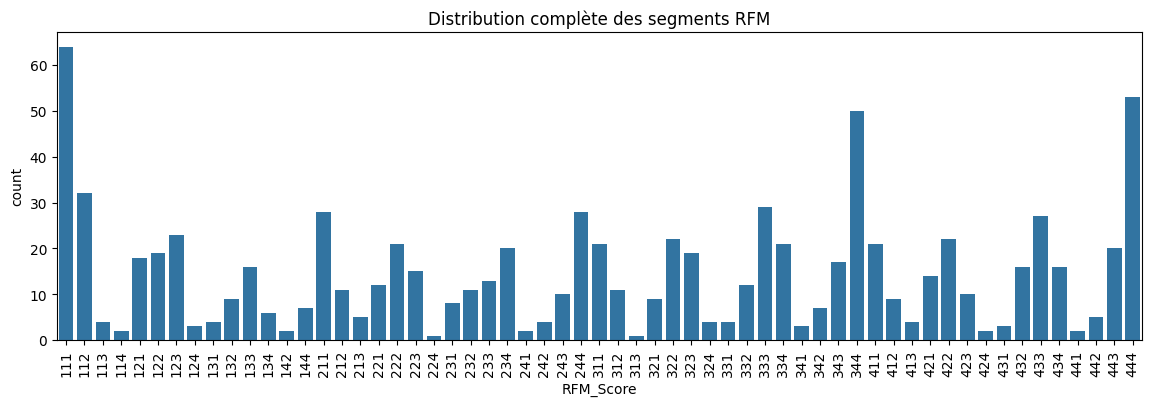

/tmp/ipython-input-96335257.py:14: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  rfm_pivot = user_features.pivot_table(index='F_quartile', columns='M_quartile', values='recency_days', aggfunc='mean')


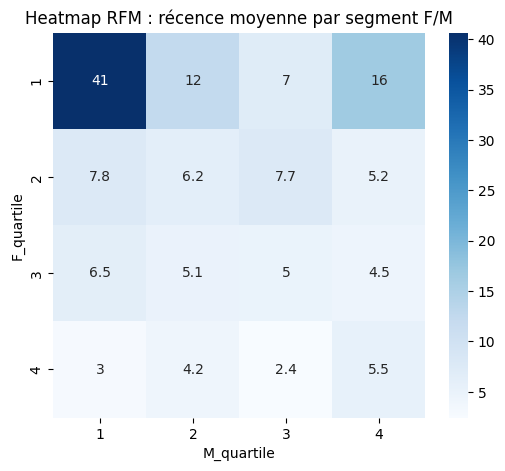

In [ ]:
# distribution du score RFM
plt.figure(figsize=(14,4))
sns.countplot(
    x='RFM_Score',
    data=user_features,
    order=sorted(user_features['RFM_Score'].unique())
)
plt.xticks(rotation=90)
plt.title('Distribution complète des segments RFM')
plt.show()


# heatmap de la récence moyenne selon F et M
rfm_pivot = user_features.pivot_table(index='F_quartile', columns='M_quartile', values='recency_days', aggfunc='mean')

plt.figure(figsize=(6,5))
sns.heatmap(rfm_pivot, cmap='Blues', annot=True)
plt.title('Heatmap RFM : récence moyenne par segment F/M')
plt.show()

Analyse démographique

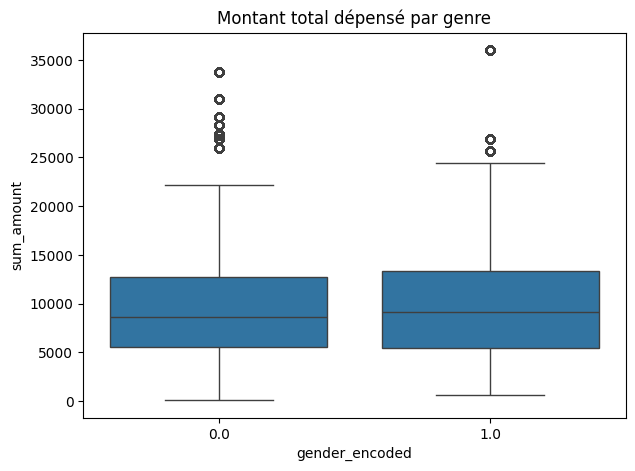

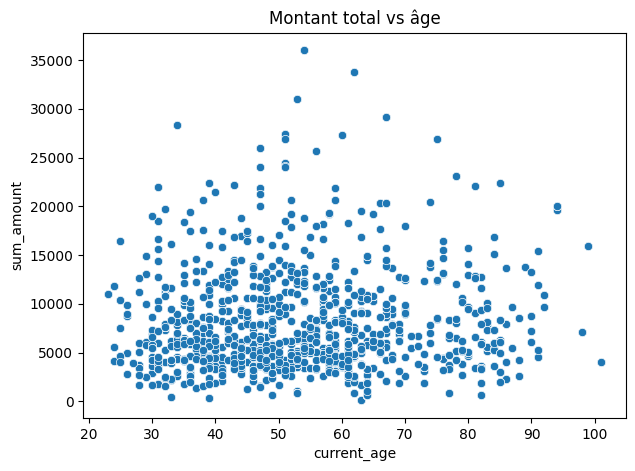

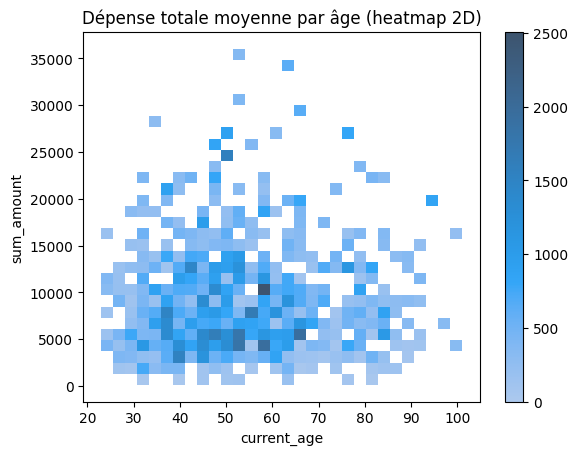

In [ ]:
#on croise les comportements rfm avec les donnees attributaires
df_merged = df.merge(user_features, on='client_id_x', how='left')

#0 homme et 1 femme
plt.figure(figsize=(7,5))
sns.boxplot(x='gender_encoded', y='sum_amount', data=df_merged)
plt.title("Montant total dépensé par genre")
plt.show()

plt.figure(figsize=(7,5))
sns.scatterplot(x='current_age', y='sum_amount', data=df_merged)
plt.title("Montant total vs âge")
plt.show()

# heatmap permet de mieux analyser
sns.histplot(x='current_age', y='sum_amount', data=df_merged, bins=30, cbar=True)
plt.title("Dépense totale moyenne par âge (heatmap 2D)")
plt.show()

In [ ]:
print("Top 10 gros dépensiers :")
print(user_features.sort_values(by='sum_amount', ascending=False).head(10))
print("\nTop 10 inactifs :")
print(user_features.sort_values(by='count_transactions').head(10))

Top 10 gros dépensiers :
     client_id_x  mean_amount  sum_amount  std_amount  count_transactions  \
722       1686.0   100.035833    36012.90   83.121194                 360   
125        285.0    53.824179    33747.76   64.089096                 627   
571       1340.0    78.799492    31047.00   87.160227                 394   
768       1797.0    45.123215    29194.72   43.462759                 647   
83         165.0    99.427263    28336.77  126.125735                 285   
487       1168.0    45.397877    27374.92   98.257325                 603   
263        630.0    83.785215    27313.98   49.032413                 326   
424       1003.0    89.751100    26925.33   97.419273                 300   
806       1888.0    33.419677    26869.42   91.742617                 804   
756       1776.0    30.575600    25989.26   59.457224                 850   

    last_transaction_date  recency_days R_quartile F_quartile M_quartile  \
722   2018-12-22 03:59:00             9          2 

Analyse par localisation

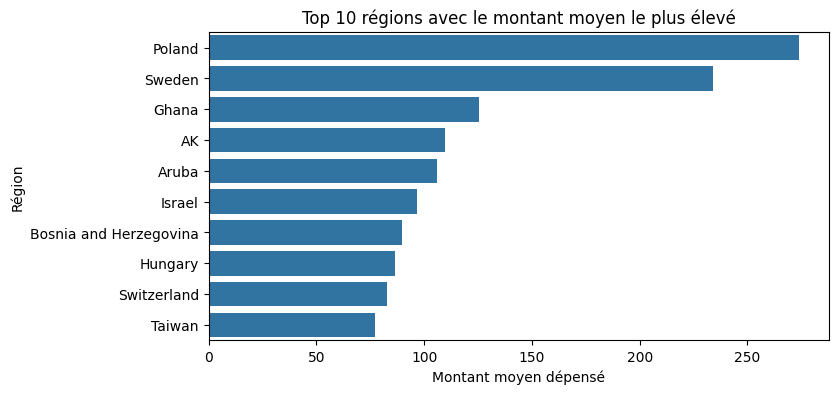

In [ ]:
# Montant moyen par région
region_stats = df.groupby('merchant_state')['amount'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(8,4))
sns.barplot(x=region_stats.values, y=region_stats.index)
plt.title("Top 10 régions avec le montant moyen le plus élevé")
plt.xlabel("Montant moyen dépensé")
plt.ylabel("Région")
plt.show()

table de synthèse RFM

In [ ]:
rfm_summary = user_features.groupby('RFM_Score')[['mean_amount', 'sum_amount', 'count_transactions', 'recency_days']].mean().round(2)
print("Synthèse RFM :")
print(rfm_summary.head(10))


Synthèse RFM :
           mean_amount  sum_amount  count_transactions  recency_days
RFM_Score                                                           
111              32.04     2818.05               91.12         81.03
112              50.39     5411.96              108.28         20.62
113              83.22     8291.51              100.25         15.25
114             104.61    11889.74              114.00         16.50
121              25.12     3596.49              143.94         16.28
122              37.88     5474.99              145.53         15.00
123              55.52     8254.03              150.61         15.91
124              90.13    14858.86              165.67         11.67
131              20.17     3988.62              198.75         13.00
132              28.52     5707.56              202.89         15.22


VIP vs inactifs

/tmp/ipython-input-2255547856.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


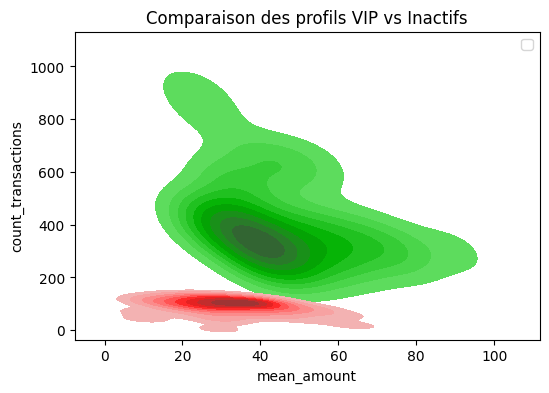

In [ ]:
vip = user_features[user_features['RFM_Score'] == '444']
inactive = user_features[user_features['RFM_Score'] == '111']

plt.figure(figsize=(6,4))
sns.kdeplot(x='mean_amount', y='count_transactions', data=vip, color='green', fill=True, label='VIP')
sns.kdeplot(x='mean_amount', y='count_transactions', data=inactive, color='red', fill=True, label='Inactifs')
plt.legend()
plt.title("Comparaison des profils VIP vs Inactifs")
plt.show()


In [ ]:
print("Résumé final :")
print(f"- {len(user_features)} utilisateurs analysés")
print(f"- {user_features['RFM_Score'].nunique()} segments RFM détectés")
print(f"- {len(vip)} clients VIP et {len(inactive)} inactifs identifiés")

Résumé final :
- 852 utilisateurs analysés
- 59 segments RFM détectés
- 53 clients VIP et 64 inactifs identifiés


Détection d'anomalies avec Isolation Forest

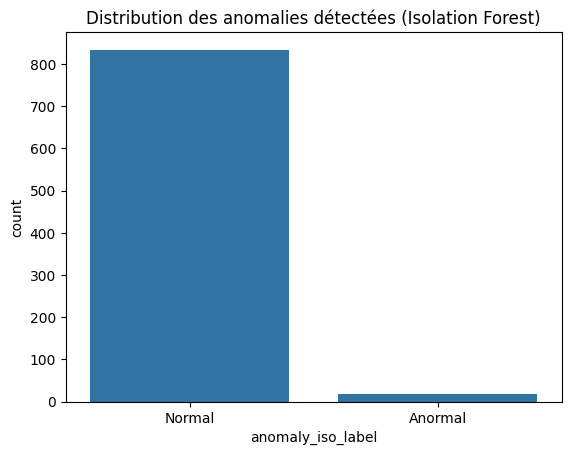

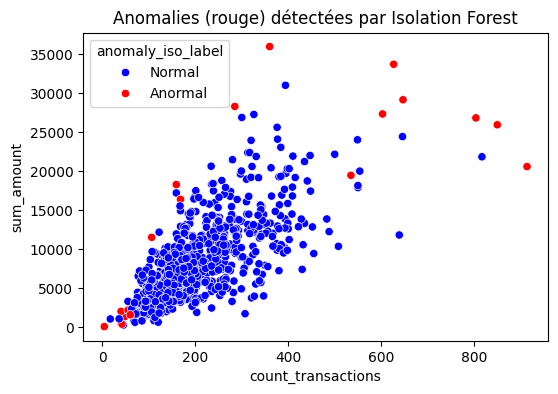

In [ ]:
# je sélectionne les features utiles à la détection d'anomalies
X_anom = user_features[['mean_amount', 'sum_amount', 'std_amount', 'count_transactions', 'recency_days']]

# modèle Isolation Forest
iso = IsolationForest(contamination=0.02, random_state=42)
user_features['anomaly_iso'] = iso.fit_predict(X_anom)

# -1 = anomalie détectée, 1 = normal
user_features['anomaly_iso_label'] = user_features['anomaly_iso'].map({1: 'Normal', -1: 'Anormal'})

sns.countplot(x='anomaly_iso_label', data=user_features)
plt.title("Distribution des anomalies détectées (Isolation Forest)")
plt.show()

# je visualise les anomalies dans l'espace montant / fréquence
plt.figure(figsize=(6,4))
sns.scatterplot(x='count_transactions', y='sum_amount', hue='anomaly_iso_label', data=user_features, palette={'Normal':'blue','Anormal':'red'})
plt.title("Anomalies (rouge) détectées par Isolation Forest")
plt.show()


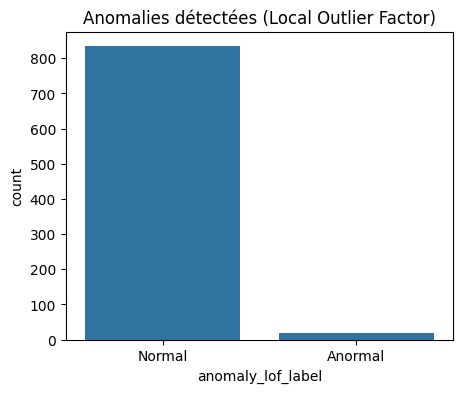

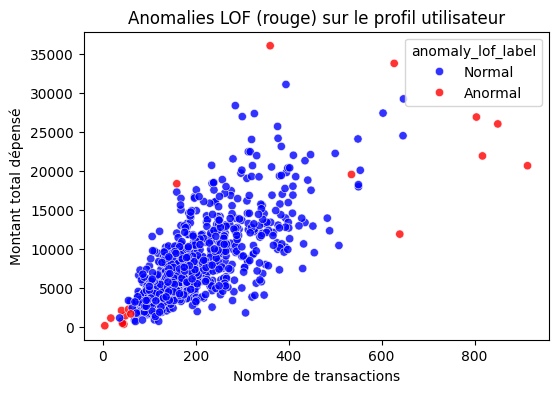

In [ ]:
# je sélectionne les mêmes features que pour Isolation Forest
X_lof = user_features[['mean_amount', 'sum_amount', 'std_amount', 'count_transactions', 'recency_days']]

# je standardise les données pour LOF
scaler_lof = StandardScaler()
X_lof_scaled = scaler_lof.fit_transform(X_lof)

# je crée et j'applique le modèle LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.02)
labels_lof = lof.fit_predict(X_lof_scaled)

# je stocke les résultats
user_features['anomaly_lof'] = labels_lof
user_features['anomaly_lof_label'] = user_features['anomaly_lof'].map({1: 'Normal', -1: 'Anormal'})

# je visualise le nombre d'anomalies détectées
plt.figure(figsize=(5,4))
sns.countplot(x='anomaly_lof_label', data=user_features)
plt.title("Anomalies détectées (Local Outlier Factor)")
plt.show()

# je visualise les anomalies LOF dans l'espace transactions / montant
plt.figure(figsize=(6,4))
sns.scatterplot(
    x='count_transactions',
    y='sum_amount',
    hue='anomaly_lof_label',
    data=user_features,
    palette={'Normal': 'blue', 'Anormal': 'red'},
    alpha=0.8
)
plt.title("Anomalies LOF (rouge) sur le profil utilisateur")
plt.xlabel("Nombre de transactions")
plt.ylabel("Montant total dépensé")
plt.show()


Clustering utilisateurs (K-Means)

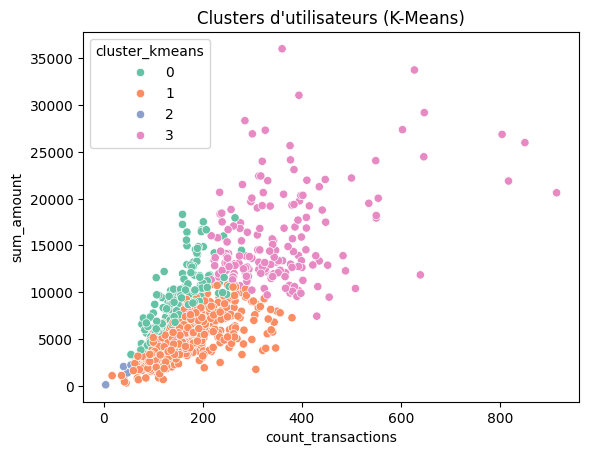

cluster_kmeans
1    481
0    197
3    170
2      4
Name: count, dtype: int64


In [ ]:
# je standardise les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_anom)

# choix du nombre de clusters (k=4 ici)
kmeans = KMeans(n_clusters=4, random_state=42)
user_features['cluster_kmeans'] = kmeans.fit_predict(X_scaled)

sns.scatterplot(x='count_transactions', y='sum_amount', hue='cluster_kmeans', data=user_features, palette='Set2')
plt.title("Clusters d'utilisateurs (K-Means)")
plt.show()

# taille des clusters
print(user_features['cluster_kmeans'].value_counts())


Clustering avec DBSCAN (profils extrêmes non linéaires)

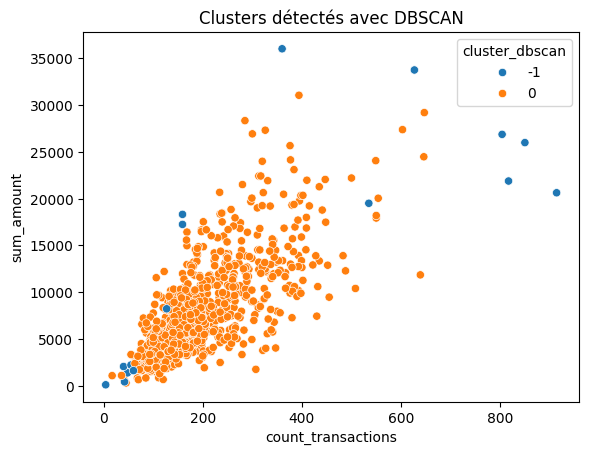

In [ ]:
dbscan = DBSCAN(eps=1.5, min_samples=5)
user_features['cluster_dbscan'] = dbscan.fit_predict(X_scaled)

sns.scatterplot(x='count_transactions', y='sum_amount', hue='cluster_dbscan', data=user_features, palette='tab10')
plt.title("Clusters détectés avec DBSCAN")
plt.show()


Évolution dans le temps (détection de changements)

503 utilisateurs ont changé brutalement de comportement.


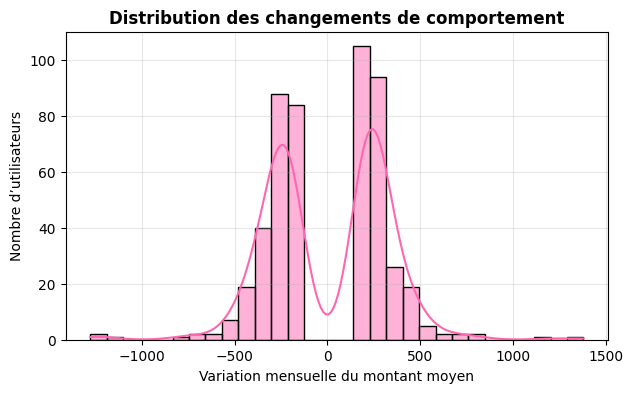

In [ ]:
#%%
# je calcule la dépense moyenne par utilisateur par mois
df['month'] = df['date'].dt.to_period('M')
user_trends = df.groupby(['client_id_x', 'month'])['amount'].mean().reset_index()

# je détecte les variations fortes entre deux mois consécutifs
user_trends['variation'] = user_trends.groupby('client_id_x')['amount'].diff()

# je récupère les clients avec fortes variations
threshold = user_trends['variation'].std() * 3
changements = user_trends[user_trends['variation'].abs() > threshold]

print(f"{len(changements)} utilisateurs ont changé brutalement de comportement.")

# version rose mais titres/labels noirs
plt.figure(figsize=(7,4))
sns.histplot(changements['variation'], bins=30, kde=True, color='#ff66b2')  # rose vif
plt.title("Distribution des changements de comportement", fontsize=12, fontweight='bold', color='black')
plt.xlabel("Variation mensuelle du montant moyen", color='black')
plt.ylabel("Nombre d’utilisateurs", color='black')
plt.grid(alpha=0.3)
plt.show()


In [ ]:
#%%
print("SYNTHÈSE GLOBALE")

# nb utilisateurs
print(f"- {len(user_features)} utilisateurs analysés")

# nb segments rfm
print(f"- {user_features['RFM_Score'].nunique()} segments RFM identifiés")

# anomalies Isolation Forest
if 'anomaly_iso_label' in user_features.columns:
    n_iso_anom = (user_features['anomaly_iso_label'] == 'Anormal').sum()
    print(f"- {n_iso_anom} anomalies détectées par Isolation Forest")
else:
    print("- Isolation Forest non exécuté sur ce notebook")

# anomalies LOF
if 'anomaly_lof_label' in user_features.columns:
    n_lof_anom = (user_features['anomaly_lof_label'] == 'Anormal').sum()
    print(f"- {n_lof_anom} anomalies détectées par Local Outlier Factor (LOF)")
else:
    print("- LOF non exécuté ou non stocké")

# clusters KMeans
if 'cluster_kmeans' in user_features.columns:
    print(f"- {user_features['cluster_kmeans'].nunique()} clusters détectés (KMeans)")
else:
    print("- Clustering KMeans non exécuté")

# clusters DBSCAN
if 'cluster_dbscan' in user_features.columns:
    print(f"- {user_features['cluster_dbscan'].nunique()} clusters détectés (DBSCAN, -1 = bruit)")
else:
    print("- Clustering DBSCAN non exécuté")

# changements de comportement
if 'variation' in locals() or 'variation' in globals():
    print(f"- {len(changements)} utilisateurs ont changé brutalement de comportement")
else:
    print("- Analyse des changements de comportement non exécutée")


SYNTHÈSE GLOBALE
- 852 utilisateurs analysés
- 59 segments RFM identifiés
- 18 anomalies détectées par Isolation Forest
- 18 anomalies détectées par Local Outlier Factor (LOF)
- 4 clusters détectés (KMeans)
- 2 clusters détectés (DBSCAN, -1 = bruit)
- Analyse des changements de comportement non exécutée


In [ ]:
# ratio entre la dépense moyenne et la fréquence
user_features['avg_per_transaction'] = user_features['sum_amount'] / user_features['count_transactions']

# intensité d’activité récente
user_features['activity_index'] = user_features['count_transactions'] / (user_features['recency_days'] + 1)

# volatilité relative (écart-type rapporté à la moyenne)
user_features['std_ratio'] = user_features['std_amount'] / (user_features['mean_amount'] + 1)

# normalisation logarithmique des montants (si très dispersés)
user_features['log_sum_amount'] = np.log1p(user_features['sum_amount'])

Profiling des clusters

In [ ]:
cluster_summary = user_features.groupby('cluster_kmeans')[[
    'mean_amount', 'sum_amount', 'count_transactions', 'recency_days'
]].mean().round(2)

print("Résumé des clusters K-Means :")
print(cluster_summary)


Résumé des clusters K-Means :
                mean_amount  sum_amount  count_transactions  recency_days
cluster_kmeans                                                           
0                     59.39     8930.03              151.06          7.42
1                     31.91     5224.49              167.64          9.44
2                     37.65     1452.00               36.75        754.50
3                     46.69    15817.02              357.08          5.14


Feature importance sur anomalies

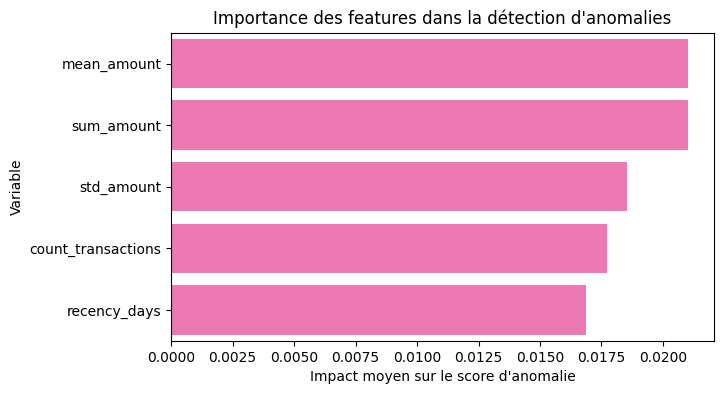

In [ ]:
# modèle IsolationForest déjà ajusté
iso = IsolationForest(contamination=0.02, random_state=42)
iso.fit(X_anom)

# score d'anomalie original
baseline_scores = iso.decision_function(X_anom)

# importance "proxy" par permutation
importances = {}
for col in X_anom.columns:
    X_permuted = X_anom.copy()
    X_permuted[col] = np.random.permutation(X_permuted[col])
    permuted_scores = iso.decision_function(X_permuted)
    diff = np.abs(baseline_scores - permuted_scores).mean()
    importances[col] = diff

# création d’un DataFrame trié
importance_df = pd.Series(importances).sort_values(ascending=False)

# affichage
plt.figure(figsize=(7,4))
sns.barplot(x=importance_df.values, y=importance_df.index, color='#ff66b2')
plt.title("Importance des features dans la détection d'anomalies")
plt.xlabel("Impact moyen sur le score d'anomalie")
plt.ylabel("Variable")
plt.show()
